In [1]:
import pandas as pd
import numpy as np

In [3]:
ben_df_folder = "/kaggle/input/modified-hate-speech-bengali-hindi/bengali-hate-speech/"
ben_df_dict = {}
ben_df_dict['train'] = pd.read_csv(ben_df_folder + "bengali-hate-speech_train.csv")
ben_df_dict['test'] = pd.read_csv(ben_df_folder + "bengali-hate-speech_test.csv")
ben_df_dict['valid'] = pd.read_csv(ben_df_folder + "bengali-hate-speech_valid.csv")

In [4]:
hin_df_folder = "/kaggle/input/modified-hate-speech-bengali-hindi/hindi-hate-speech/"
hin_df_dict = {}
hin_df_dict['train'] = pd.read_csv(hin_df_folder + "hindi-hate-speech_train.csv")
hin_df_dict['test'] = pd.read_csv(hin_df_folder + "hindi-hate-speech_test.csv")
hin_df_dict['valid'] = pd.read_csv(hin_df_folder + "hindi-hate-speech_valid.csv")

In [5]:
merged_df_dict = {}
for key in ben_df_dict.keys():
    merged_df_dict[key] = pd.concat([ben_df_dict[key], hin_df_dict[key]], axis=0, ignore_index=True)

In [6]:
from datasets import Dataset, DatasetDict

In [7]:
merged_dataset_dict = DatasetDict()
for key in merged_df_dict.keys():
    merged_dataset_dict[key] = Dataset.from_pandas(merged_df_dict[key])

In [8]:
features = merged_dataset_dict['train'].column_names
features.remove('text')
num_features = len(features)
features, num_features

(['defamation', 'hate', 'non-hate', 'violence', 'vulgar'], 5)

In [9]:
import tensorflow as tf
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification

2024-05-02 13:57:42.613572: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 13:57:42.613688: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 13:57:42.751981: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [10]:
import tensorflow as tf
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification

In [11]:
model_name = "FacebookAI/xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    problem_type="multi_label_classification",
    num_labels=num_features
)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
def tokenize_dataset(dataset):
    encoding = tokenizer(
        dataset['text'],
        padding="max_length",
        max_length=256,
        truncation=True
    )
    labels_batch = {k: dataset[k] for k in dataset.keys() if k in features}
    labels_matrix = np.zeros((len(dataset['text'],), len(features)))
    for idx, label in enumerate(features):
        labels_matrix[:, idx] = labels_batch[label]
    encoding['labels'] = labels_matrix.tolist()
    return encoding

encoded_dataset_dict_tokenized = merged_dataset_dict.map(
    tokenize_dataset,
    batched=True,
    remove_columns=['text'] + features
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/16979 [00:00<?, ? examples/s]

Map:   0%|          | 0/4868 [00:00<?, ? examples/s]

Map:   0%|          | 0/2418 [00:00<?, ? examples/s]

In [13]:
encoded_dataset_dict_tokenized.set_format(
    type='torch'
)

In [14]:
encoded_dataset_dict_tokenized

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 16979
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 4868
    })
    valid: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2418
    })
})

In [15]:
import sklearn.metrics as matrices
from transformers import EvalPrediction
from transformers import TrainingArguments, Trainer

In [16]:
args = TrainingArguments(
    output_dir='./results/',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,
    learning_rate=1e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
)

In [17]:
# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    probs = tf.math.sigmoid(predictions)
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = matrices.f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = matrices.roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = matrices.accuracy_score(y_true, y_pred)
    hamming_loss = matrices.hamming_loss(y_true, y_pred)
    jaccard_score = matrices.jaccard_score(y_true, y_pred, average='micro')
    zero_one_loss = matrices.zero_one_loss(y_true, y_pred)
    # return as dictionary
    metrics = {
        'f1': f1_micro_average,
        'roc_auc': roc_auc,
        'accuracy': accuracy,
        'hamming_loss': hamming_loss,
        'jaccard_score': jaccard_score,
        'zero_one_loss': zero_one_loss
    }
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result

In [18]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset_dict_tokenized['train'],
    eval_dataset=encoded_dataset_dict_tokenized['valid'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [19]:
trainer.train(resume_from_checkpoint=True)

Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy,Hamming Loss,Jaccard Score,Zero One Loss,Runtime,Samples Per Second,Steps Per Second
6,0.180300,0.198606,0.805205,0.874197,0.724566,0.082961,0.673927,0.275434,20.396200,118.551000,3.726000
7,0.173500,0.195216,0.812362,0.870912,0.739454,0.077337,0.684015,0.260546,19.709800,122.680000,3.856000
8,0.164200,0.191798,0.814054,0.875868,0.744417,0.077916,0.686418,0.255583,19.719300,122.621000,3.854000
9,0.156700,0.197930,0.815557,0.877987,0.744417,0.077667,0.688557,0.255583,19.697300,122.758000,3.858000
10,0.145600,0.192321,0.817242,0.880754,0.746071,0.077502,0.690963,0.253929,19.688400,122.813000,3.860000


TrainOutput(global_step=5310, training_loss=0.0805124336716819, metrics={'train_runtime': 2233.6513, 'train_samples_per_second': 76.015, 'train_steps_per_second': 2.377, 'total_flos': 2.242161251006976e+16, 'train_loss': 0.0805124336716819, 'epoch': 10.0})

In [20]:
trainer.evaluate()

{'eval_loss': 0.1923208236694336,
 'eval_f1': 0.8172420518821923,
 'eval_roc_auc': 0.8807541575757418,
 'eval_accuracy': 0.7460711331679074,
 'eval_hamming_loss': 0.07750206782464847,
 'eval_jaccard_score': 0.6909630606860159,
 'eval_zero_one_loss': 0.2539288668320926,
 'eval_runtime': 19.664,
 'eval_samples_per_second': 122.966,
 'eval_steps_per_second': 3.865,
 'epoch': 10.0}

In [21]:
actual_labels = encoded_dataset_dict_tokenized['test']['labels']
pred_labels = trainer.predict(
    encoded_dataset_dict_tokenized['test']
)

In [22]:
probs = tf.math.sigmoid(pred_labels.predictions)
y_pred = np.zeros(probs.shape)
y_pred[np.where(probs >= 0.3)] = 1

In [23]:
print('Accuracy Score: ', matrices.accuracy_score(actual_labels, y_pred))
print('F1 Score: ', matrices.f1_score(actual_labels, y_pred, average='micro'))
print('ROC AUC: ', matrices.roc_auc_score(actual_labels, y_pred, average='micro'))
print('Hamming Loss: ', matrices.hamming_loss(actual_labels, y_pred))
print('Jaccard Score: ', matrices.jaccard_score(actual_labels, y_pred, average='micro'))
print('Zero-One Loss:', matrices.zero_one_loss(actual_labels, y_pred))

print('\nClassification Report :-\n',
      matrices.classification_report(
          actual_labels,
          y_pred,
          output_dict=False,
          target_names=features,
      )
     )

Accuracy Score:  0.7043960558751027
F1 Score:  0.7997836473451727
ROC AUC:  0.8868691277575139
Hamming Loss:  0.09124897288414133
Jaccard Score:  0.6663662310350007
Zero-One Loss: 0.2956039441248973

Classification Report :-
               precision    recall  f1-score   support

  defamation       0.61      0.79      0.69       997
        hate       0.55      0.65      0.60       598
    non-hate       0.94      0.95      0.94      2421
    violence       0.67      0.79      0.73       482
      vulgar       0.68      0.81      0.74       730

   micro avg       0.76      0.85      0.80      5228
   macro avg       0.69      0.80      0.74      5228
weighted avg       0.77      0.85      0.81      5228
 samples avg       0.75      0.80      0.77      5228



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
import matplotlib.pyplot as plt

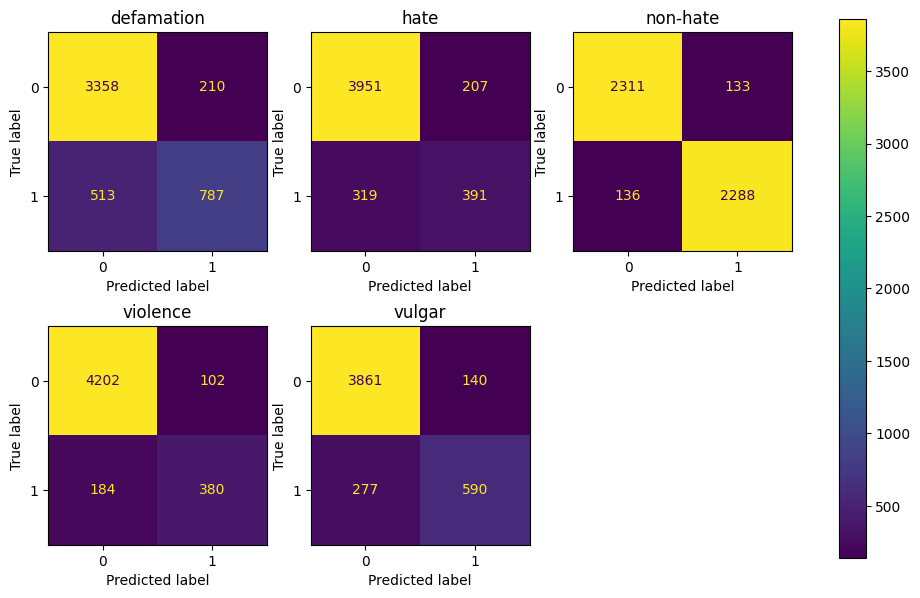

In [25]:
confusion_matrices =  matrices.multilabel_confusion_matrix(
    y_pred,
    actual_labels
)

fig, axis = plt.subplots(2, 3, figsize=(12, 7))
axis = axis.ravel()
for i in range(len(confusion_matrices)):
    disp = matrices.ConfusionMatrixDisplay(
        confusion_matrices[i],
    )
    disp.plot(ax=axis[i], values_format='.4g')
    disp.ax_.set_title(features[i])
    disp.im_.colorbar.remove()
fig.colorbar(disp.im_, ax=axis)
axis[5].remove()

In [26]:
import os

In [27]:
trained_model_name = model_name.split('/')[1] + '-hate-speech-ben-hin-epochs-' + str(args.num_train_epochs)
trainer.save_model('./' + trained_model_name)

In [28]:
os.system("cd /kaggle/working/; zip -r "+trained_model_name+".zip ./"+trained_model_name)

  adding: xlm-roberta-base-hate-speech-ben-hin-epochs-10/ (stored 0%)
  adding: xlm-roberta-base-hate-speech-ben-hin-epochs-10/tokenizer.json (deflated 76%)
  adding: xlm-roberta-base-hate-speech-ben-hin-epochs-10/config.json (deflated 53%)
  adding: xlm-roberta-base-hate-speech-ben-hin-epochs-10/special_tokens_map.json (deflated 52%)
  adding: xlm-roberta-base-hate-speech-ben-hin-epochs-10/model.safetensors (deflated 30%)
  adding: xlm-roberta-base-hate-speech-ben-hin-epochs-10/sentencepiece.bpe.model (deflated 49%)
  adding: xlm-roberta-base-hate-speech-ben-hin-epochs-10/tokenizer_config.json (deflated 77%)
  adding: xlm-roberta-base-hate-speech-ben-hin-epochs-10/training_args.bin (deflated 51%)


0